In [1]:
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.lines as mlines

In [2]:
# plotting defaults
plt.rcParams.update({
    "figure.figsize": (7.5, 5),
    "axes.grid": True,
    "grid.alpha": 0.25
})

# paths
base_dir   = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\Processed"
meta_path  = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\ap_VolFilt.csv"
transect_meta = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\NESLTER_transect_metadata.csv")
chl_path   = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Chl\chl_conc.csv"
depth_df = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\depth_partitioning2.csv")

# sample keys
SAMPLE_KEYS = ["cruise", "cast", "niskin"]

# Load absorption spectra

In [3]:
CCN_PATTERN = re.compile(r'^([A-Za-z0-9]+)_C(\d+)N(\d+)', re.IGNORECASE)

def parse_ccn_from_filename(path):
    """Return (cruise, cast, niskin) from filename."""
    fname = os.path.basename(path)
    m = CCN_PATTERN.search(fname)
    if not m:
        return (pd.NA, pd.NA, pd.NA)
    return m.group(1).lower(), int(m.group(2)), int(m.group(3))

def find_processed_files(base_dir):
    """Return sorted list of '*_Processed.csv' files."""
    files = sorted(glob.glob(os.path.join(base_dir, "*_Processed.csv")))
    if not files:
        raise FileNotFoundError("No '*_Processed.csv' files in base_dir")
    return files

def load_one_absorption_file(fp):
    """Load one processed ap file and extract standard columns."""
    df = pd.read_csv(fp)

    if "Wavelength" not in df or "Phytoplankton_Absorption" not in df:
        raise KeyError(f"{os.path.basename(fp)} missing required columns")

    cruise, cast, niskin = parse_ccn_from_filename(fp)

    out = pd.DataFrame({
        "Wavelength": pd.to_numeric(df["Wavelength"], errors="coerce"),
        "aph":        pd.to_numeric(df["Phytoplankton_Absorption"], errors="coerce"),
        "cruise":     cruise,
        "cast":       cast,
        "niskin":     niskin,
        "filename":   os.path.basename(fp),
    })
    return out

def build_abs_df(files):
    """Combine rows from all files into one cleaned dataframe."""
    pieces = [load_one_absorption_file(f) for f in files]
    out = pd.concat(pieces, ignore_index=True)
    out = out.dropna(subset=["Wavelength", "aph"])
    out["Wavelength"] = out["Wavelength"].astype(int)
    return out

def print_abs_summary(abs_df):
    """Simple summary line."""
    unique_samples = abs_df[SAMPLE_KEYS + ["filename"]].drop_duplicates().shape[0]
    print(f"Loaded {len(abs_df):,} rows from {unique_samples} samples")

proc_files = find_processed_files(base_dir)
abs_df = build_abs_df(proc_files)

# Load cruise metadata

In [4]:
meta = pd.read_csv(meta_path, encoding="latin-1")

meta["cruise"] = meta["cruise"].astype(str).str.lower()
meta["cast"]   = pd.to_numeric(meta["cast"], errors="coerce").astype("Int64")
meta["niskin"] = pd.to_numeric(meta["niskin"], errors="coerce").astype("Int64")

In [5]:
meta.columns

Index(['cruise', 'cast', 'niskin', 'p_filename', 'd_filename', 'Ap_vol',
       'station', 'depth', 'date_UTC', 'Lat', 'Lon'],
      dtype='object')

In [6]:
if "depth" in meta.columns:
    meta["depth"] = meta["depth"].replace("surface", 1)
    meta["depth"] = pd.to_numeric(meta["depth"], errors="coerce")

# keep one metadata row per sample
meta = meta.drop_duplicates(SAMPLE_KEYS, keep="first")

# merge with absorption
out = abs_df.merge(meta, on=SAMPLE_KEYS, how="left")

In [7]:
# Drop rows with missing or non-numeric 'cast'
transect_meta = transect_meta[transect_meta["cast"].apply(lambda x: str(x).isdigit())]
transect_meta["cast"] = transect_meta["cast"].astype(int)

In [8]:
# Make sure datatypes align
depth_df["cruise"] = depth_df["cruise"].astype(str).str.lower()
depth_df["cast"]   = pd.to_numeric(depth_df["cast"], errors="coerce").astype("Int64")
depth_df["niskin"] = pd.to_numeric(depth_df["niskin"], errors="coerce").astype("Int64")

# Merge depth categories onto wide table
out = out.merge(
    depth_df[["cruise","cast","niskin","depth_cat"]],
    on=["cruise","cast","niskin"], how="left"
)

out.head()

,Wavelength,aph,cruise,cast,niskin,filename,p_filename,d_filename,Ap_vol,station,depth,date_UTC,Lat,Lon,depth_cat
0,300,0.106301,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM
1,301,0.105738,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM
2,302,0.104157,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM
3,303,0.102127,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM
4,304,0.099830,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM


# Load Chl Concentration Data

In [9]:
chl_raw = pd.read_csv(chl_path, encoding="latin-1")
chl_raw

,cruise,cast,niskin,chl_0_avg,chl_5_avg,chl_10_avg,chl_20_avg,date,longitude,latitude,depth
0,AR28B,1,2,1.211422,NaN,NaN,NaN,,NaN,NaN,NaN
1,AR28B,1,5,0.876879,NaN,NaN,NaN,,NaN,NaN,NaN
2,AR28B,1,8,0.844588,NaN,NaN,NaN,,NaN,NaN,NaN
3,AR28B,2,1,6.212741,NaN,NaN,NaN,2018-04-03 22:19:16+00:00,-70.883167,41.031333,39.722652
4,AR28B,2,5,4.855188,NaN,NaN,NaN,2018-04-03 22:22:32+00:00,-70.883167,41.031333,26.802747
...,...,...,...,...,...,...,...,...,...,...,...
671,EN720,20,17,0.286606,NaN,NaN,NaN,2024-09-10 20:54:35+00:00,-70.883360,40.861620,15.522000
672,EN720,20,20,0.200447,NaN,0.183725,NaN,2024-09-10 20:58:31+00:00,-70.882820,40.861410,3.939000
673,EN720,24,2,3.145140,NaN,NaN,NaN,2024-09-11 05:38:01+00:00,-70.580550,41.317980,15.633000
674,EN720,24,4,4.793017,NaN,5.369058,NaN,2024-09-11 05:39:59+00:00,-70.581560,41.317860,8.467000


In [10]:
chl_col = 'chl_0_avg'
chl = chl_raw[SAMPLE_KEYS + [chl_col]].rename(columns={chl_col: "Chl"}).copy()

# standardize keys
chl["cruise"] = chl["cruise"].astype(str).str.lower()
chl["cast"]   = pd.to_numeric(chl["cast"], errors="coerce").astype("Int64")
chl["niskin"] = pd.to_numeric(chl["niskin"], errors="coerce").astype("Int64")

In [11]:
# merge chl with spectra
out_star = out.merge(chl, on=SAMPLE_KEYS, how="left")

In [12]:
out_star.head()

,Wavelength,aph,cruise,cast,niskin,filename,p_filename,d_filename,Ap_vol,station,depth,date_UTC,Lat,Lon,depth_cat,Chl
0,300,0.106301,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM,NaN
1,301,0.105738,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM,NaN
2,302,0.104157,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM,NaN
3,303,0.102127,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM,NaN
4,304,0.099830,ae2426,1,2,AE2426_C01N02_Processed.csv,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17.0,20241106.0,41.19714,-70.8827,DCM,NaN


## Calculate aph*

In [13]:
out_star["aph_star"] = np.where(
    out_star["Chl"] > 0,
    out_star["aph"] / out_star["Chl"],
    np.nan
)

In [14]:
desired_order = [
    "cruise", "cast", "niskin", "filename", "station", "date_UTC",
    "Lat", "Lon", "depth", "depth_cat",
    "Wavelength", "aph", "Chl", "aph_star"
]

out_star = out_star[desired_order]
out_star = out_star.rename(columns={"station": "Station"})
out_star.head()

,cruise,cast,niskin,filename,Station,date_UTC,Lat,Lon,depth,depth_cat,Wavelength,aph,Chl,aph_star
0,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.8827,17.0,DCM,300,0.106301,NaN,NaN
1,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.8827,17.0,DCM,301,0.105738,NaN,NaN
2,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.8827,17.0,DCM,302,0.104157,NaN,NaN
3,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.8827,17.0,DCM,303,0.102127,NaN,NaN
4,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.8827,17.0,DCM,304,0.099830,NaN,NaN


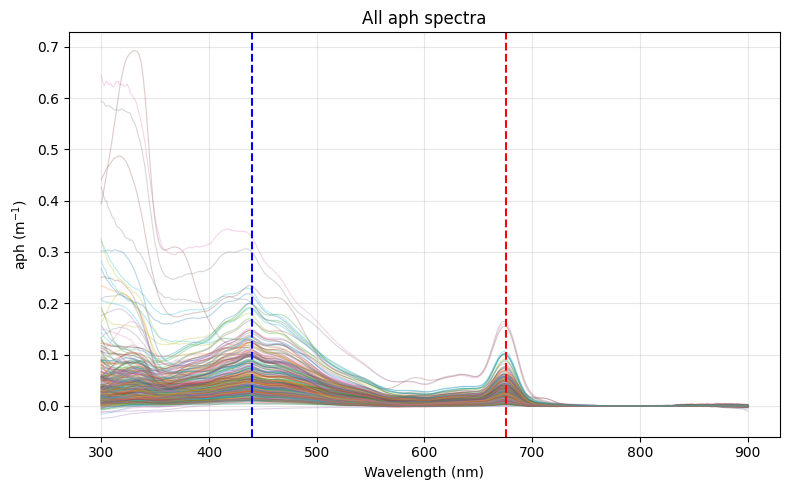

In [15]:
def plot_all_aph(df, title="All aph spectra"):
    plt.figure(figsize=(8,5))
    for (cr, ca, ni, fn), g in df.groupby(SAMPLE_KEYS + ["filename"]):
        plt.plot(g["Wavelength"], g["aph"], alpha=0.3, lw=0.8)

    # Vertical lines for blue (440 nm) and red (676 nm)
    plt.axvline(440, color="blue",  linestyle="--", linewidth=1.5)
    plt.axvline(676, color="red",   linestyle="--", linewidth=1.5)
    
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("aph (m$^{-1}$)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_all_aph(out_star)

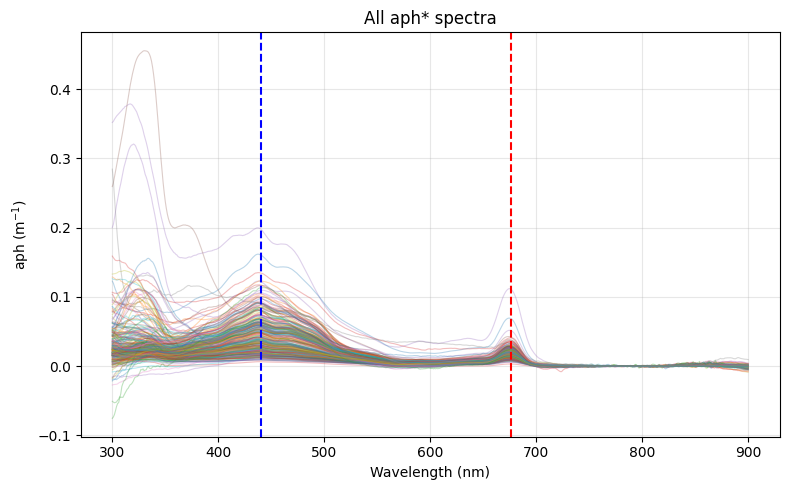

In [16]:
def plot_all_aph_star(df, title="All aph* spectra"):
    plt.figure(figsize=(8,5))
    
    # Plot all spectra
    for (cr, ca, ni, fn), g in df.groupby(SAMPLE_KEYS + ["filename"]):
        plt.plot(g["Wavelength"], g["aph_star"], alpha=0.3, lw=0.8)
    
    # Vertical lines for blue (440 nm) and red (676 nm)
    plt.axvline(440, color="blue",  linestyle="--", linewidth=1.5)
    plt.axvline(676, color="red",   linestyle="--", linewidth=1.5)
    
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("aph (m$^{-1}$)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_all_aph_star(out_star)

# Organize Metadata

In [17]:
# make sure you kept aph_raw
out_star["aph_raw"] = out_star["aph"]

wide = (out_star
    .pivot_table(
        index=SAMPLE_KEYS + ["filename", "Station", "date_UTC", "Lat", "Lon", "depth", "depth_cat"],
        columns="Wavelength", values=["aph_raw", "aph_star"], aggfunc="mean"
    )
    .reset_index()
)

# flatten MultiIndex
wide.columns = [
    f"{val}_{col}" if isinstance(col, (int, np.integer)) else val
    for val, col in wide.columns
]

wide = wide.merge(chl, on=SAMPLE_KEYS, how="left")
wide.head()

,cruise,cast,niskin,filename,Station,date_UTC,Lat,Lon,depth,depth_cat,...,aph_star_892,aph_star_893,aph_star_894,aph_star_895,aph_star_896,aph_star_897,aph_star_898,aph_star_899,aph_star_900,Chl
0,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.88270,17.0,DCM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ae2426,1,13,AE2426_C01N13_Processed.csv,L1,20241106.0,41.19590,-70.88358,3.0,Surface,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ae2426,4,4,AE2426_C04N04_Processed.csv,L2,20241107.0,41.03141,-70.88173,27.0,DCM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ae2426,4,10,AE2426_C04N10_Processed.csv,L2,20241107.0,41.03156,-70.88124,15.0,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ae2426,4,16,AE2426_C04N16_Processed.csv,L2,20241107.0,41.03166,-70.88078,2.0,Surface,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Keep wavelengths of interest only

In [18]:
keep_cols = [
    "aph_raw_440", "aph_star_440",
    "aph_raw_676", "aph_star_676"
]

wide = wide[[c for c in wide.columns if "aph" not in c.lower()] + keep_cols].copy()

## Stations

In [19]:
# Normalize station names
wide["station_norm"] = (wide["Station"].astype(str).str.strip().str.upper())

# Ordering function
def station_key(s):
    if s == "MVCO":
        return (0, 0)
    m = re.fullmatch(r"L(\d+)", s)
    if m:
        return (1, int(m.group(1)))
    return (2, s)

# Ordered categories
station_labels = sorted(wide["station_norm"].dropna().unique().tolist(), key=station_key)

# Make the normalized column categorical
wide["station_norm"] = pd.Categorical(wide["station_norm"], categories=station_labels, ordered=True)

# Overwrite old station and drop the extra column
wide["station"] = wide["station_norm"]
wide = wide.drop(columns=["station_norm"])

print("Stations in order:", station_labels)
wide.head()

Stations in order: ['MVCO', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11']


,cruise,cast,niskin,filename,Station,date_UTC,Lat,Lon,depth,depth_cat,Chl,aph_raw_440,aph_star_440,aph_raw_676,aph_star_676,station
0,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.88270,17.0,DCM,NaN,0.081836,NaN,0.044099,NaN,L1
1,ae2426,1,13,AE2426_C01N13_Processed.csv,L1,20241106.0,41.19590,-70.88358,3.0,Surface,NaN,0.117388,NaN,0.061098,NaN,L1
2,ae2426,4,4,AE2426_C04N04_Processed.csv,L2,20241107.0,41.03141,-70.88173,27.0,DCM,NaN,0.100549,NaN,0.053124,NaN,L2
3,ae2426,4,10,AE2426_C04N10_Processed.csv,L2,20241107.0,41.03156,-70.88124,15.0,Other,NaN,0.096698,NaN,0.049394,NaN,L2
4,ae2426,4,16,AE2426_C04N16_Processed.csv,L2,20241107.0,41.03166,-70.88078,2.0,Surface,NaN,0.109820,NaN,0.057132,NaN,L2


## Months

In [20]:
wide["date_UTC"] = wide["date_UTC"].astype(str)
wide["month_num"] = pd.to_numeric(wide["date_UTC"].str.slice(4,6), errors="coerce")

MONTH_NAMES = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
wide["month_name"] = wide["month_num"].map(MONTH_NAMES)
wide.head()

,cruise,cast,niskin,filename,Station,date_UTC,Lat,Lon,depth,depth_cat,Chl,aph_raw_440,aph_star_440,aph_raw_676,aph_star_676,station,month_num,month_name
0,ae2426,1,2,AE2426_C01N02_Processed.csv,L1,20241106.0,41.19714,-70.88270,17.0,DCM,NaN,0.081836,NaN,0.044099,NaN,L1,11,Nov
1,ae2426,1,13,AE2426_C01N13_Processed.csv,L1,20241106.0,41.19590,-70.88358,3.0,Surface,NaN,0.117388,NaN,0.061098,NaN,L1,11,Nov
2,ae2426,4,4,AE2426_C04N04_Processed.csv,L2,20241107.0,41.03141,-70.88173,27.0,DCM,NaN,0.100549,NaN,0.053124,NaN,L2,11,Nov
3,ae2426,4,10,AE2426_C04N10_Processed.csv,L2,20241107.0,41.03156,-70.88124,15.0,Other,NaN,0.096698,NaN,0.049394,NaN,L2,11,Nov
4,ae2426,4,16,AE2426_C04N16_Processed.csv,L2,20241107.0,41.03166,-70.88078,2.0,Surface,NaN,0.109820,NaN,0.057132,NaN,L2,11,Nov


## Seasons

In [21]:
SEASON_ORDER = ["Winter", "Spring", "Summer", "Fall"]

# Climatological season (DJF, MAM, JJA, SON)
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    if m in [3, 4, 5]:
        return "Spring"
    if m in [6, 7, 8]:
        return "Summer"
    if m in [9, 10, 11]:
        return "Fall"
    return np.nan

wide["season"] = wide["month_num"].apply(month_to_season)
wide["season"] = pd.Categorical(wide["season"], categories=SEASON_ORDER, ordered=True)

# Ecological grouping (JFM, AMJ, JAS, OND)
def month_to_season2(m):
    if m in [1, 2, 3]:
        return "Winter"  # JFM
    if m in [4, 5, 6]:
        return "Spring"  # AMJ
    if m in [7, 8, 9]:
        return "Summer"  # JAS
    if m in [10, 11, 12]:
        return "Fall"    # OND
    return np.nan

wide["season_2"] = wide["month_num"].apply(month_to_season2)
wide["season_2"] = pd.Categorical(wide["season_2"], categories=SEASON_ORDER, ordered=True)

In [22]:
cols_aph = [c for c in wide.columns if c.lower().startswith("aph")]
cols_other = [c for c in wide.columns if not c.lower().startswith("aph")]

wide = wide[cols_other + cols_aph]

# Compute Blue:Red

In [23]:
wide["blue_red"] = wide["aph_raw_440"] / wide["aph_raw_676"]
wide["blue_red_star"] = wide["aph_star_440"] / wide["aph_star_676"]
wide = wide[wide["aph_raw_676"] > 0].copy()
wide.columns

Index(['cruise', 'cast', 'niskin', 'filename', 'Station', 'date_UTC', 'Lat',
       'Lon', 'depth', 'depth_cat', 'Chl', 'station', 'month_num',
       'month_name', 'season', 'season_2', 'aph_raw_440', 'aph_star_440',
       'aph_raw_676', 'aph_star_676', 'blue_red', 'blue_red_star'],
      dtype='object')

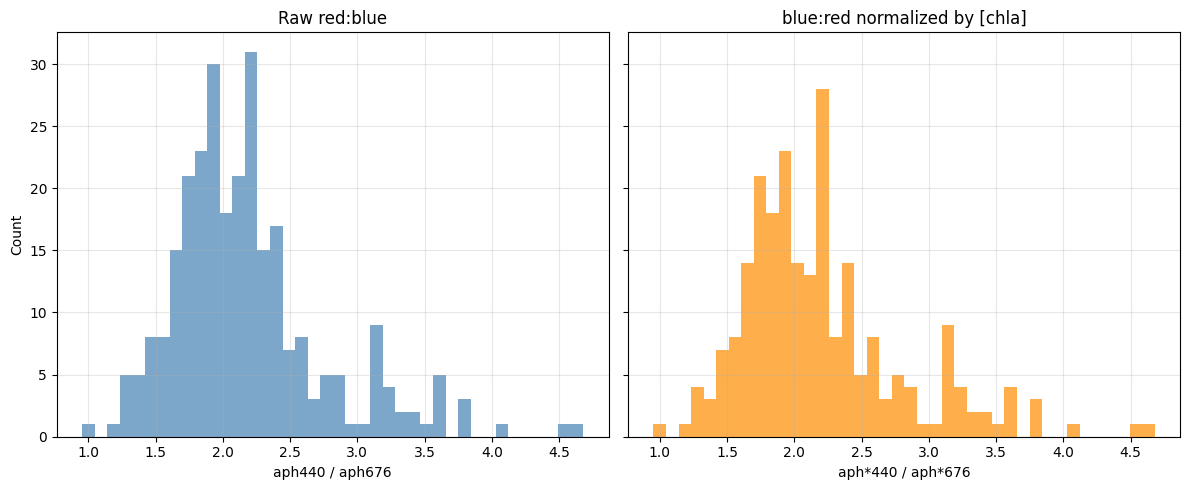

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Panel 1: raw red:blue
axes[0].hist(
    wide["blue_red"].dropna(),
    bins=40, color="steelblue", alpha=0.7
)
axes[0].set_xlabel("aph440 / aph676")
axes[0].set_ylabel("Count")
axes[0].set_title("Raw red:blue")
axes[0].grid(True, alpha=0.3)

# Panel 2: normalized red:blue*
axes[1].hist(
    wide["blue_red_star"].dropna(),
    bins=40, color="darkorange", alpha=0.7
)
axes[1].set_xlabel("aph*440 / aph*676")
axes[1].set_title("blue:red normalized by [chla]")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


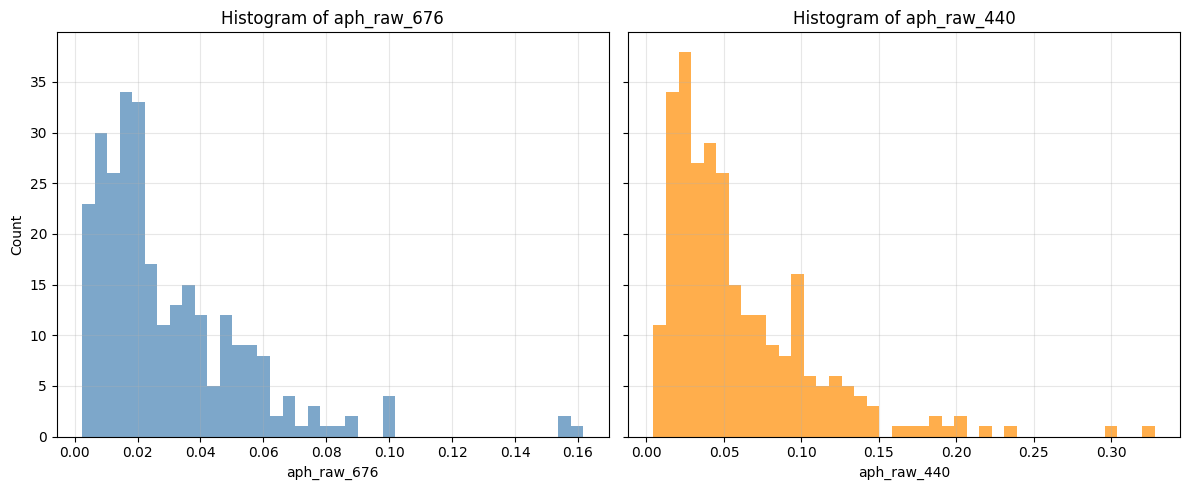

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Panel 1: aph_raw_676
axes[0].hist(
    wide["aph_raw_676"].dropna(),
    bins=40, color="steelblue", alpha=0.7
)
axes[0].set_xlabel("aph_raw_676")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of aph_raw_676")
axes[0].grid(True, alpha=0.3)

# Panel 2: aph_raw_440
axes[1].hist(
    wide["aph_raw_440"].dropna(),
    bins=40, color="darkorange", alpha=0.7
)
axes[1].set_xlabel("aph_raw_440")
axes[1].set_title("Histogram of aph_raw_440")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Export Cleaned Data

In [26]:
out_star.to_csv(rf'C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\Compiled\ap_data_compiled.csv', na_rep="NaN", index=False)
wide.to_csv(rf'C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\Compiled\ap_metrics_compiled.csv', na_rep="NaN", index=False)

# Plotting

## Helper Functions

In [27]:
def plot_counts_by_station_season(df, value_col=None, title="Sample counts by station & season", season_choice="season"):
    if value_col:
        df = df.dropna(subset=[value_col])

    counts = (
        df.groupby(["station", season_choice],  observed = True)
        .size()
        .reset_index(name="n_samples")
    )

    plt.figure(figsize=(11,5))
    sns.barplot(
        data=counts, x="station", y="n_samples", hue=season_choice,
        order=station_labels, hue_order=SEASON_ORDER,
        palette="Set2"
    )

    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [28]:
def plot_red_and_or_blue_summer_winter(df, red_col="aph_star_red", blue_col="aph_star_blue",
                                    season_col="season_2", ylim=(0,0.125), Title = "Mean ± SD a$_{ph}^*$ (Red & Blue)"):
    df_sub = df[df[season_col].isin(["Summer", "Winter"])].copy()
    if df_sub.empty:
        print(f"No data found for Summer/Winter in '{season_col}'")
        return

    def stats_by_season(sub, var):
        grouped = sub.groupby("station", observed = True)[var]
        mean = grouped.mean()
        sd = grouped.std()
        return mean.index, mean.values, sd.values

    fig, ax = plt.subplots(figsize=(12, 6))
    linestyles = {"Summer": "solid", "Winter": "dashed"}
    colors = {red_col: "crimson", blue_col: "royalblue"}

    for season in ["Summer", "Winter"]:
        sub = df_sub[df_sub[season_col] == season]
        for var in [red_col, blue_col]:
            x, y, yerr = stats_by_season(sub, var)
            if len(x) == 0:
                continue
            ax.errorbar(
                x, y, yerr=yerr,
                color=colors[var],
                fmt="o-", lw=2, capsize=4,
                linestyle=linestyles[season],
                label=f"{var.replace('aph_star_', '').capitalize()} ({season})"
            )

    # Custom legend (no markers so dashed/solid are clear)
    handles = []
    for var, color in colors.items():
        for season, style in linestyles.items():
            label = f"{var.replace('aph_star_', '').capitalize()} ({season})"
            handles.append(
                mlines.Line2D([], [], color=color, linestyle=style, lw=3, label=label)
            )
    ax.legend(handles=handles, frameon=False, ncol=2)

    ax.set_ylabel("a$_{ph}^*$ (m$^2$ mg Chl$^{-1}$)")
    ax.set_xlabel("Station (inshore to offshore)")
    ax.set_title(Title)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [29]:
# Boxplots (stations on x-axis, split by season)
def plot_box_by_station_season(df, value_col, ylabel, title, showfliers=False, ylim=None, season_choice="season"):
    plt.figure(figsize=(11,5))

    sns.boxplot(
        data=df, x="station", y=value_col, hue=season_choice,
        order=station_labels,
        hue_order=SEASON_ORDER,
        palette="Set2", showfliers=showfliers,
        boxprops=dict(edgecolor="none")
    )

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("")
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [30]:
# Lineplot summary (mean ± SD across stations)
def plot_point_by_station_season(df, value_col, ylabel, title, ylim=None, season_choice="season"):
    plt.figure(figsize=(11,5))

    sns.pointplot(
        data=df, x="station", y=value_col, hue=season_choice,
        order=station_labels,
        hue_order=SEASON_ORDER,
        palette="Set2", dodge=0.3, markers="o", errorbar="sd"
    )

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel("")
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [31]:
season_scheme = "season_2"
winter_summer_wide = wide[wide["season"].isin(["Winter", "Summer"])].copy()
surface_WS_wide =  winter_summer_wide[winter_summer_wide["depth_cat"].isin(["Surface"])].copy()
dcm_WS_wide = winter_summer_wide[winter_summer_wide["depth_cat"].isin(["DCM"])].copy()

## All Depths

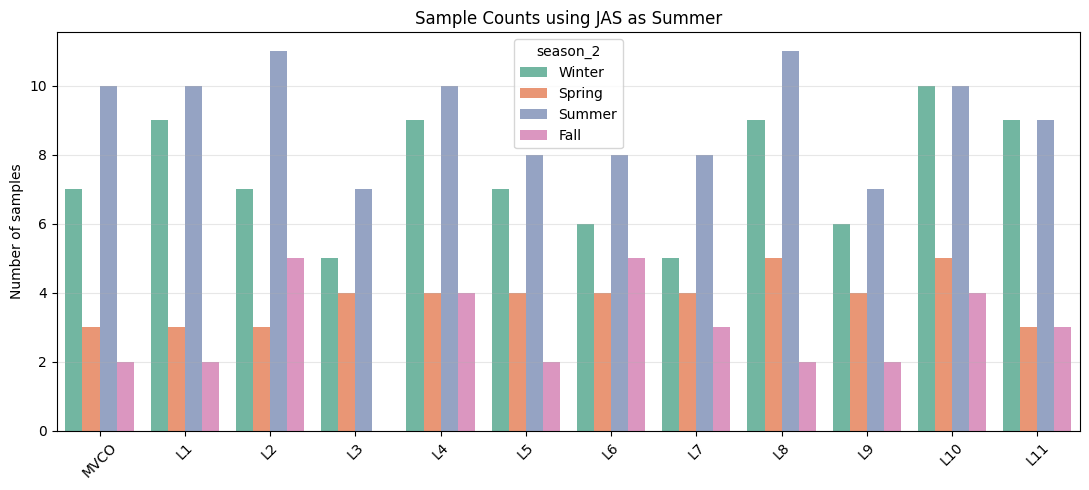

In [32]:
# All samples
plot_counts_by_station_season(wide, season_choice="season_2", title = "Sample Counts using JAS as Summer")

### Red and Blue Metric

C:\Users\ocron\AppData\Local\Temp\ipykernel_70772\216385979.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


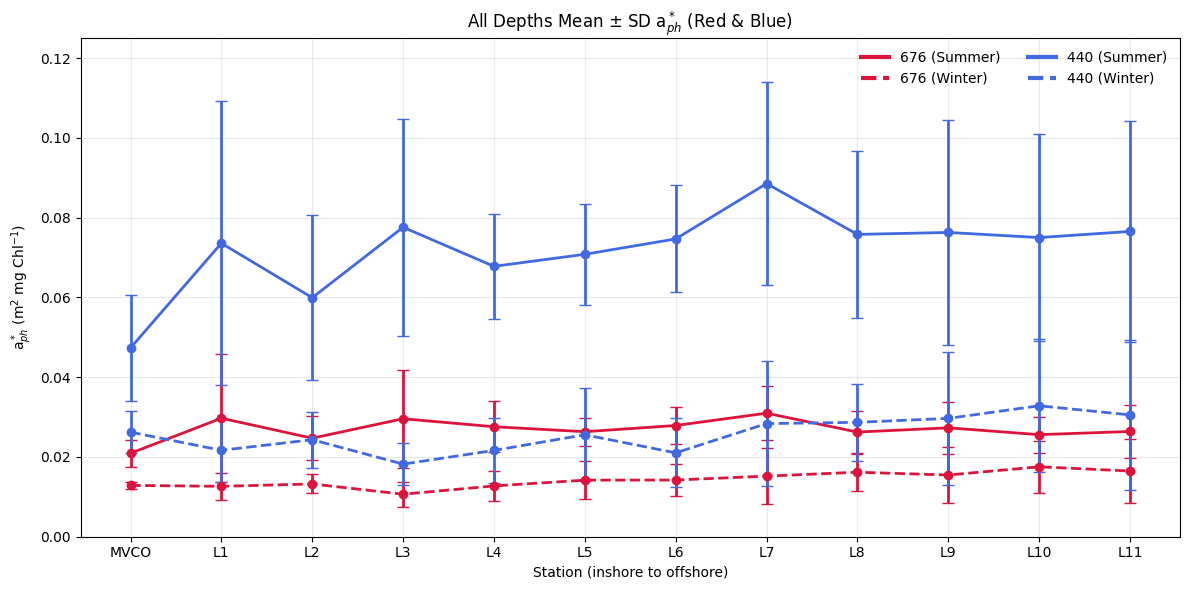

In [33]:
plot_red_and_or_blue_summer_winter(winter_summer_wide, red_col="aph_star_676", blue_col="aph_star_440", season_col="season_2", ylim=(0, 0.125), Title = "All Depths Mean ± SD a$_{ph}^*$ (Red & Blue)")

### Red:Blue Metric

## Surface Samples

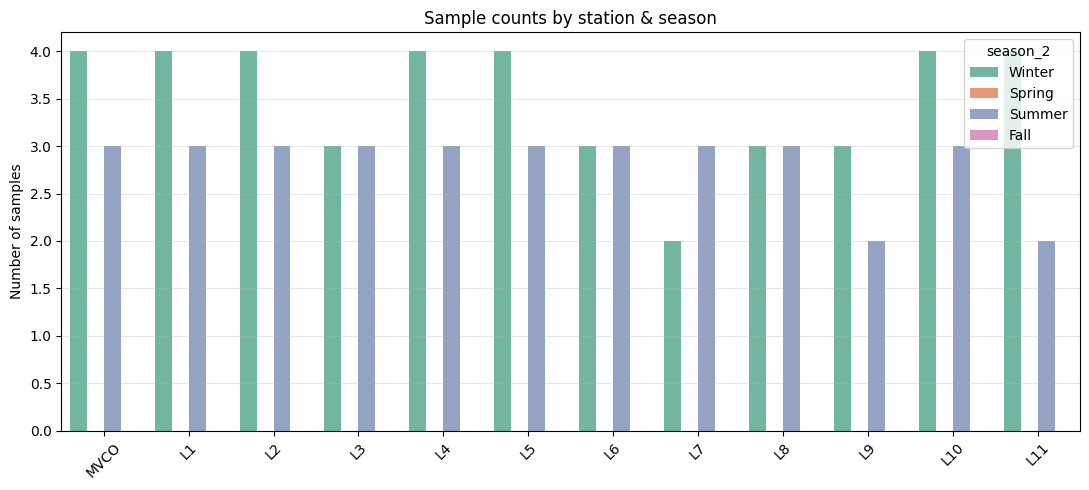

In [34]:
# All samples
plot_counts_by_station_season(surface_WS_wide, season_choice = season_scheme)

### Red and Blue Metric

C:\Users\ocron\AppData\Local\Temp\ipykernel_70772\216385979.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


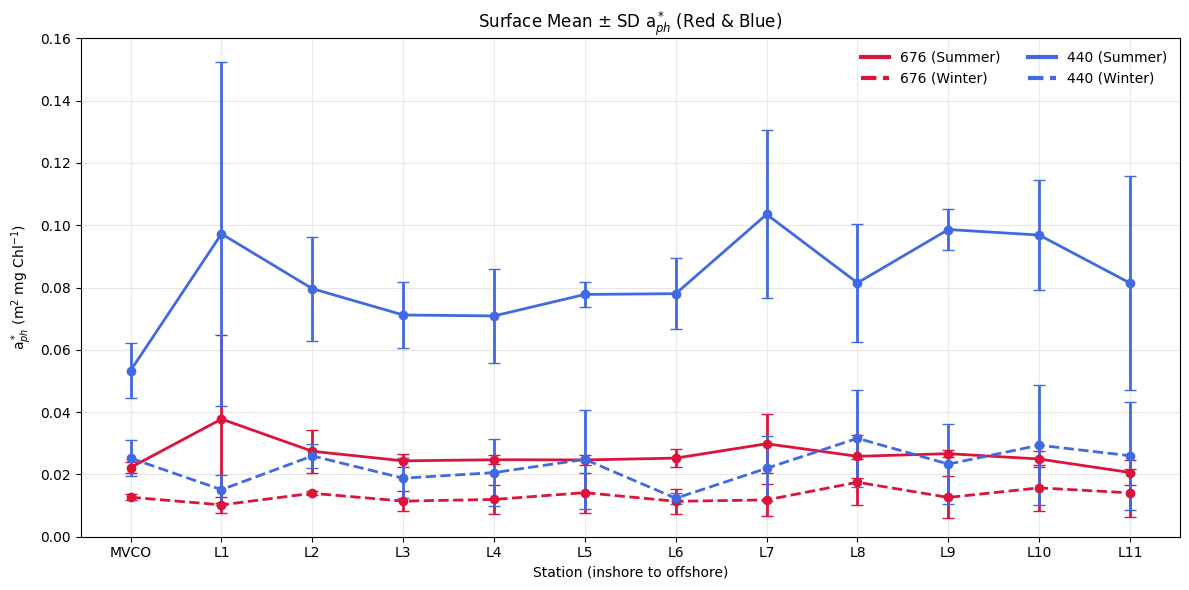

In [35]:
plot_red_and_or_blue_summer_winter(surface_WS_wide, red_col="aph_star_676", blue_col="aph_star_440", season_col="season_2", ylim=(0, 0.16), Title = "Surface Mean ± SD a$_{ph}^*$ (Red & Blue)")

### Red:Blue Metric

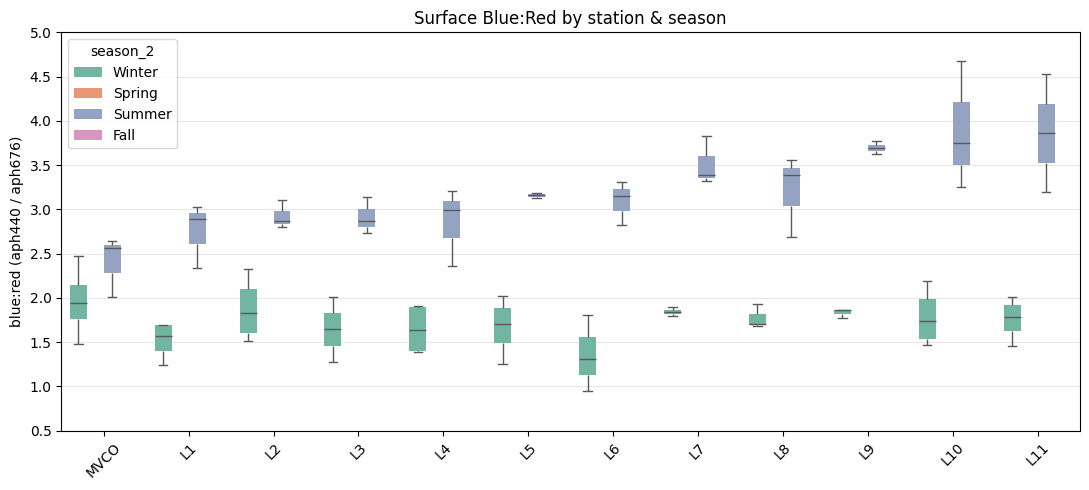

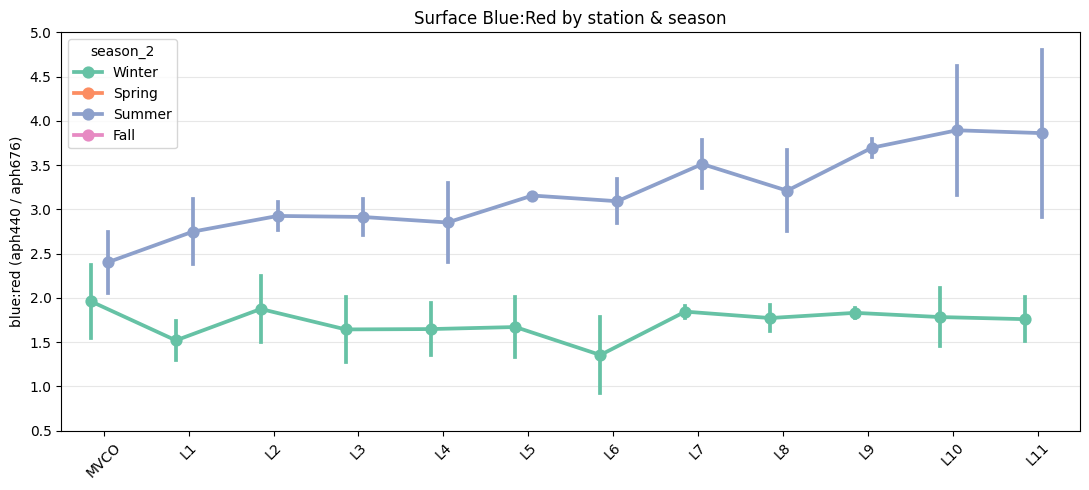

In [36]:
# Red:Blue ratio
plot_box_by_station_season(
    surface_WS_wide.dropna(subset=["blue_red"]),
    value_col="blue_red",
    ylabel="blue:red (aph440 / aph676)",
    title="Surface Blue:Red by station & season",
    ylim=(0.5,5), season_choice = season_scheme
)

# Curvature summary
plot_point_by_station_season(
    surface_WS_wide.dropna(subset=["blue_red"]),
    value_col="blue_red",
    ylabel="blue:red (aph440 / aph676)",
    title="Surface Blue:Red by station & season",
    ylim=(0.5,5), season_choice = season_scheme
)


## DCM Samples

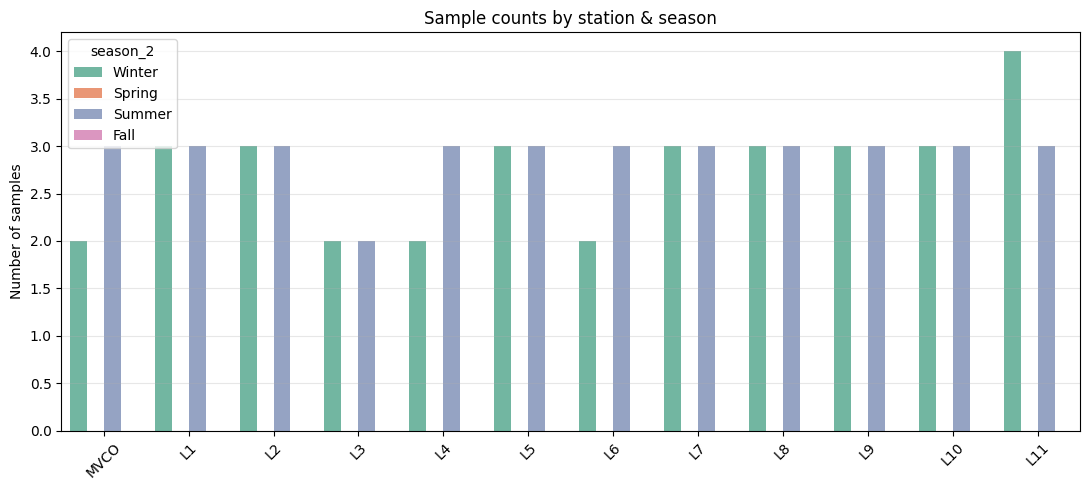

In [37]:
# All samples
plot_counts_by_station_season(dcm_WS_wide, season_choice = season_scheme)

### Red and Blue Metric

C:\Users\ocron\AppData\Local\Temp\ipykernel_70772\216385979.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


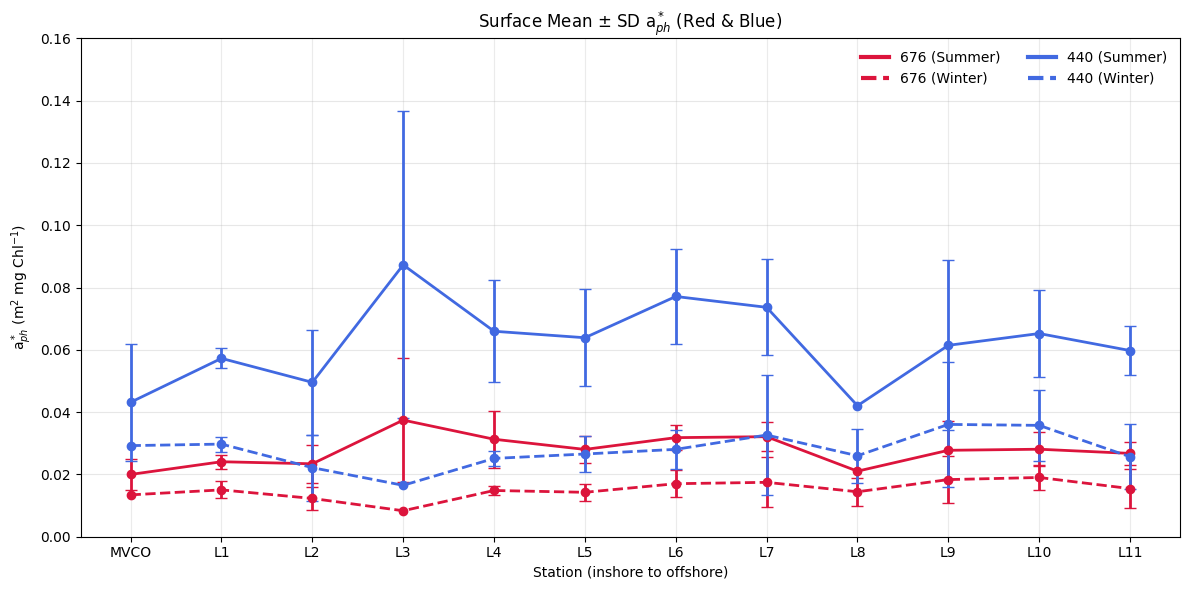

In [38]:
# Advisor-defined scheme (JFM–AMJ–JAS–OND)
plot_red_and_or_blue_summer_winter(dcm_WS_wide, red_col="aph_star_676", blue_col="aph_star_440", season_col="season_2", ylim=(0, 0.16), Title = "Surface Mean ± SD a$_{ph}^*$ (Red & Blue)")

### Red:Blue Metric

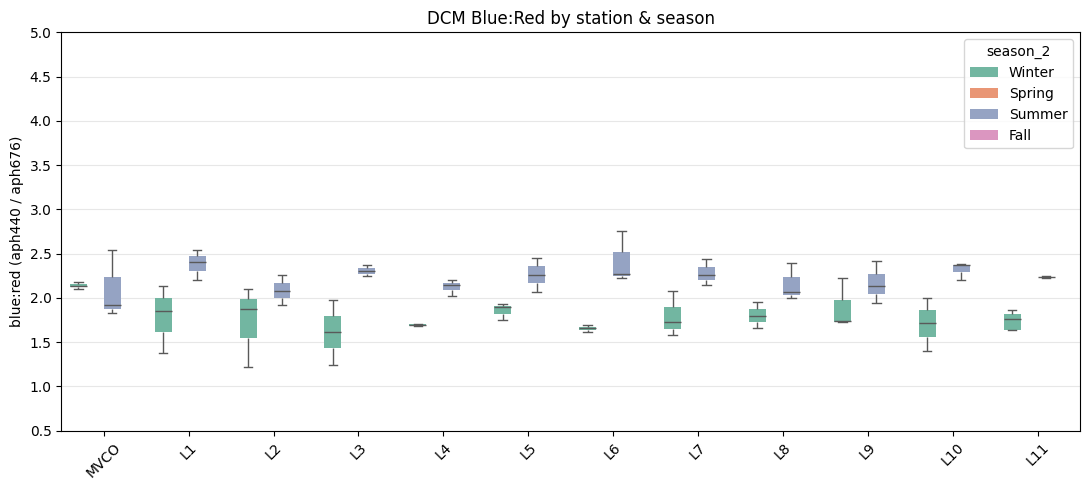

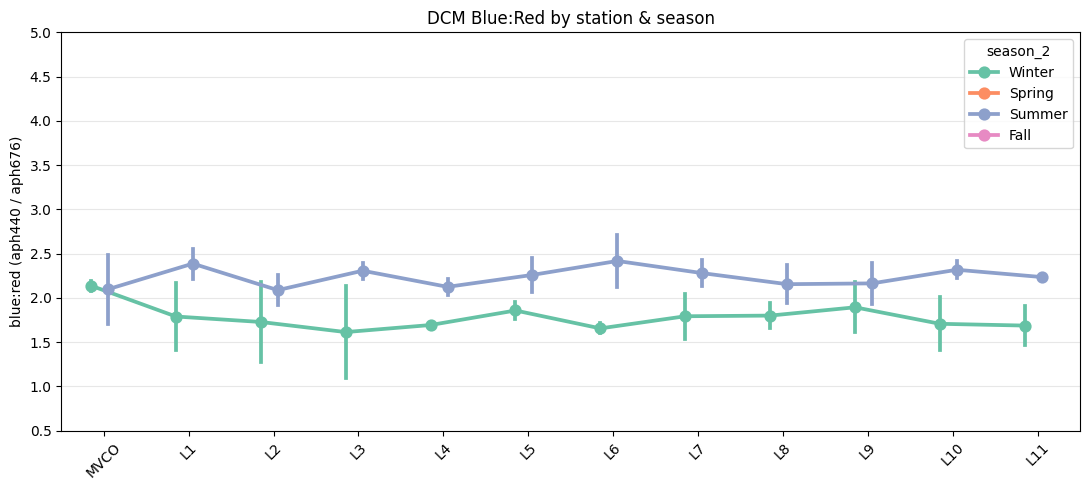

In [39]:
# Red:Blue ratio
plot_box_by_station_season(
    dcm_WS_wide.dropna(subset=["blue_red"]),
    value_col="blue_red",
    ylabel="blue:red (aph440 / aph676)",
    title="DCM Blue:Red by station & season",
    ylim=(0.5,5), season_choice = season_scheme
)

# Curvature summary
plot_point_by_station_season(
    dcm_WS_wide.dropna(subset=["blue_red"]),
    value_col="blue_red",
    ylabel="blue:red (aph440 / aph676)",
    title="DCM Blue:Red by station & season",
    ylim=(0.5,5), season_choice = season_scheme
)

## Combine figures

In [40]:
def plot_redblue_transect(df, value_col="red_blue_star", season_label="Summer",
                          season_col="season_2", ylim=(0.5, 5)):
    """
    Plot red:blue ratio by station for a given season.
    Shows mean ± SD for Surface and DCM samples.
    """
    # --- Subset ---
    sub = df[df[season_col] == season_label].copy()
    if sub.empty:
        print(f"No data found for {season_label} in '{season_col}'")
        return

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    sns.pointplot(
        data=sub,
        x="station", y=value_col, hue="depth_cat",
        hue_order=["Surface", "DCM"],
        order=station_labels,
        palette={"Surface": "purple", "DCM": "seagreen"},
        dodge=0.3, markers="o", errorbar="sd"
    )

    plt.ylabel("Blue:Red ratio")
    plt.xlabel("Station (inshore to offshore)")
    plt.title(f"{season_label}: mean ± SD {value_col} by station")
    if ylim:
        plt.ylim(ylim)
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()


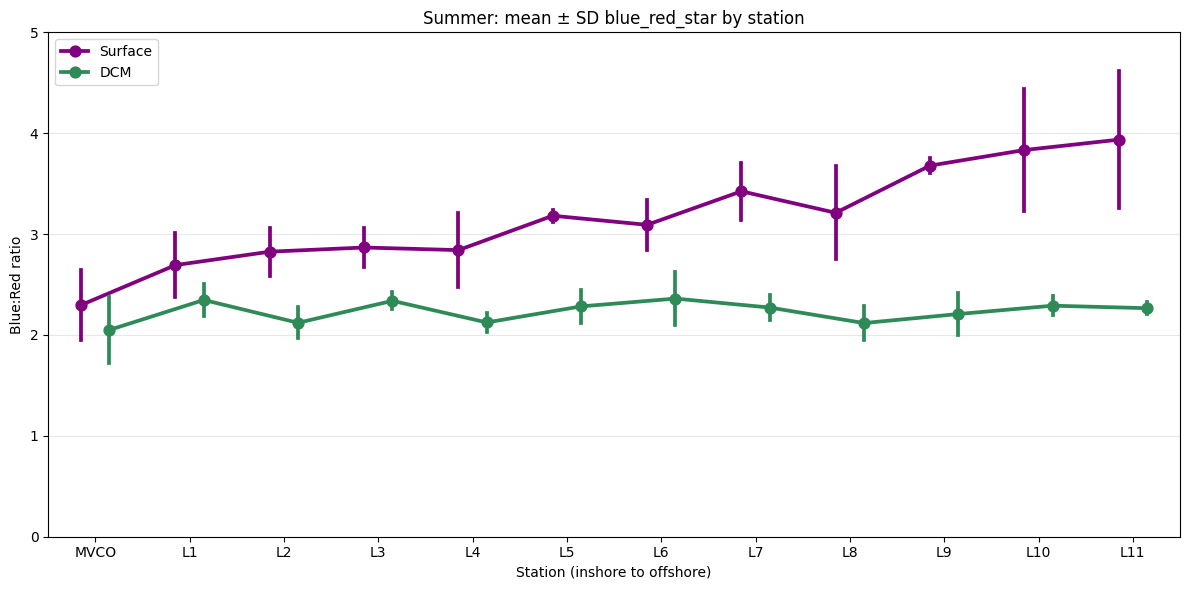

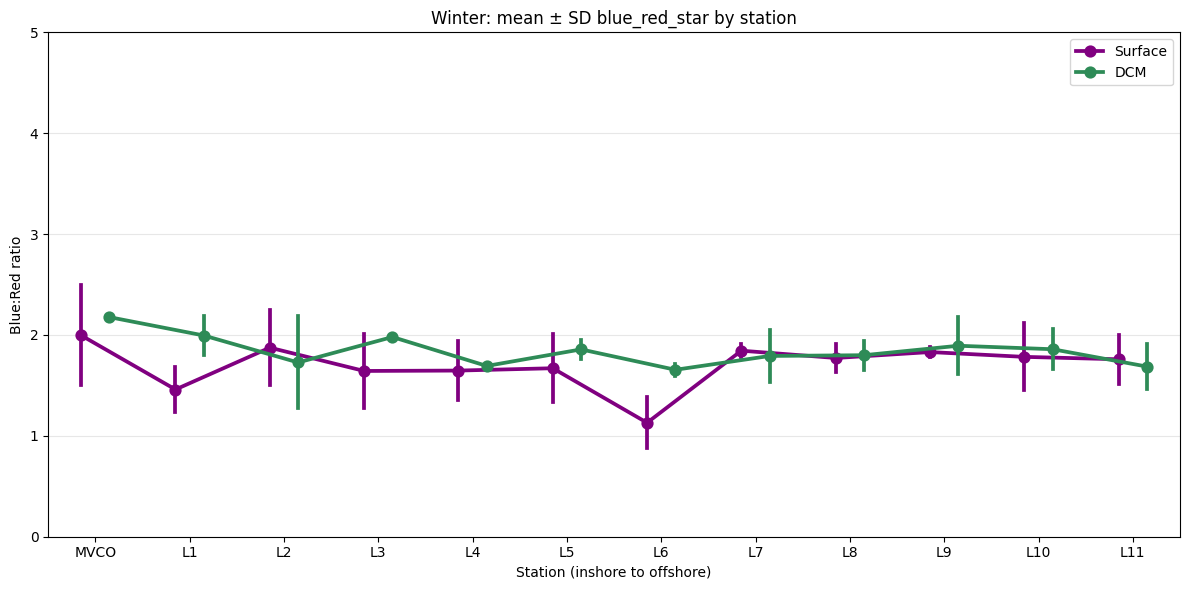

In [41]:
# For advisor’s season scheme (JFM, AMJ, JAS, OND)
plot_redblue_transect(wide, value_col="blue_red_star", season_label="Summer", season_col="season_2", ylim=(0,5))

# For climatological seasons (DJF, MAM, JJA, SON)
plot_redblue_transect(wide, value_col="blue_red_star", season_label="Winter", season_col="season_2", ylim=(0,5))


In [42]:
def plot_redblue_summer_winter(df, value_col="red_blue_star", season_col="season_2", ylim=(0.5, 5)):
    # --- Subset ---
    df_sub = df[df[season_col].isin(["Summer", "Winter"])].copy()

    # --- Compute stats ---
    def stats_by_depth(sub, depth_filter):
        sub = sub[sub["depth_cat"] == depth_filter]
        grouped = sub.groupby("station")[value_col]
        mean = grouped.mean()
        sd = grouped.std()
        return mean.index, mean.values, sd.values

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {"Surface": "purple", "DCM": "seagreen"}
    linestyles = {"Summer": "solid", "Winter": "dashed"}

    for season in ["Summer", "Winter"]:
        sub = df_sub[df_sub[season_col] == season]
        for zone in ["Surface", "DCM"]:
            x, y, yerr = stats_by_depth(sub, zone)
            if len(x) == 0:
                continue
            ax.errorbar(
                x, y, yerr=yerr,
                color=colors[zone],
                fmt="o-", lw=2, capsize=4,
                linestyle=linestyles[season],
                label=f"{zone} ({season})"
            )

    # --- Custom legend (longer clean line, no marker) ---
    handles = []
    for zone, color in colors.items():
        for season, style in linestyles.items():
            handles.append(
                mlines.Line2D([], [], color=color, linestyle=style, lw=3,
                              label=f"{zone} ({season})")  # no marker
            )

    ax.legend(handles=handles, title="", ncol=2, frameon=False)

    # --- Labels and formatting ---
    ax.set_ylabel("Blue:Red ratio")
    ax.set_xlabel("Station (inshore to offshore)")
    ax.set_title("Mean ± SD Blue:Red by station — Summer (solid) vs Winter (dashed)")
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


C:\Users\ocron\AppData\Local\Temp\ipykernel_70772\274890022.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sub.groupby("station")[value_col]
C:\Users\ocron\AppData\Local\Temp\ipykernel_70772\274890022.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(


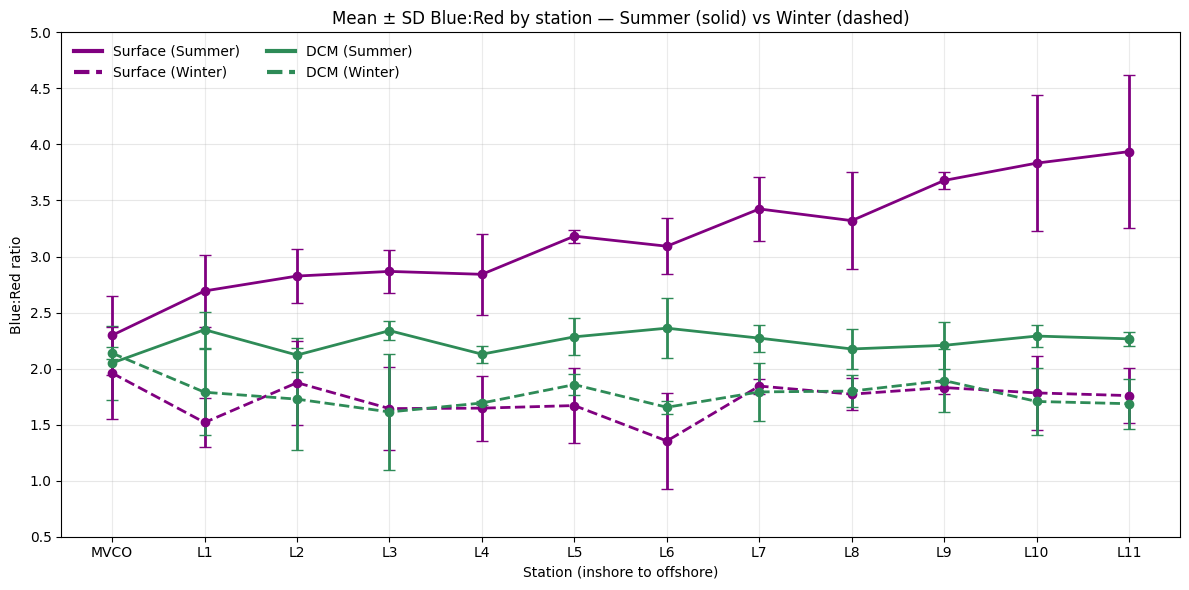

In [43]:
# Advisor-defined scheme (JFM–AMJ–JAS–OND)
plot_redblue_summer_winter(wide, value_col="blue_red", season_col="season_2", ylim=(0.5,5))